In [1]:
import librosa
import librosa.display
from scipy.io import wavfile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tqdm import tqdm

from utils import *

/Users/lorenzo/opt/anaconda3/envs/data_science/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load training and evaluation csv

path = './summer_2022_project/'
audio_path = path + 'audio/'

df = pd.read_csv(path+'development.csv', dtype={'filename':'string', 'emotion':'string'}) # set string as type
eval_df = pd.read_csv(path+'evaluation.csv', dtype={'filename':'string'}) # set string as type

labels = df.emotion.unique()
labels_dict = {v:k for k,v in enumerate(labels)} #needed to transform categorical labels

df['encoded_emotion'] = df['emotion'].map(labels_dict)
df.head()

,emotion,filename,encoded_emotion
0,Disgusted,0.wav,0
1,Fearful,1.wav,1
2,Neutral,2.wav,2
3,Happy,3.wav,3
4,Angry,4.wav,4


/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_6406/1699259855.py:7: FutureWarning: Pass sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sr)


Text(0.5, 1.0, "Waveform of '0.wav'")

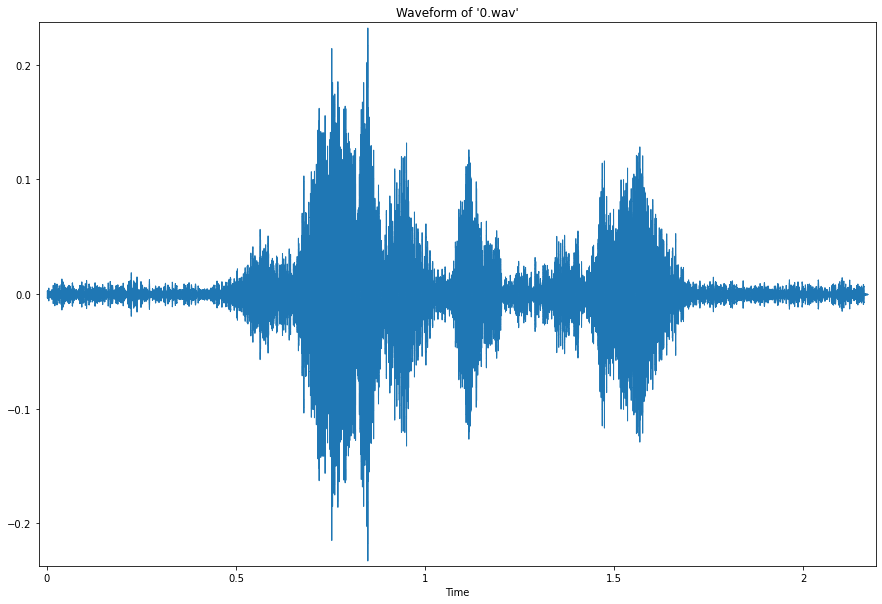

In [23]:
# Example of audio waveform (time domain)
filenames = list(df.filename)
audio_file = audio_path+filenames[0]
signal, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast', mono=True)

plt.figure(figsize=(15,10))
librosa.display.waveshow(signal, sr)
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.title(f"Waveform of '{filenames[0]}'")

(array([9.28135718e-05, 6.08942171e-05, 9.87795360e-06, ...,
        1.32388974e-07, 1.41151995e-07, 9.00670785e-10]),
 array([0.00000000e+00, 1.15260489e-04, 2.30520977e-04, ...,
        9.99769479e-01, 9.99884740e-01, 1.00000000e+00]),
 <matplotlib.lines.Line2D at 0x1a3e5a980>)

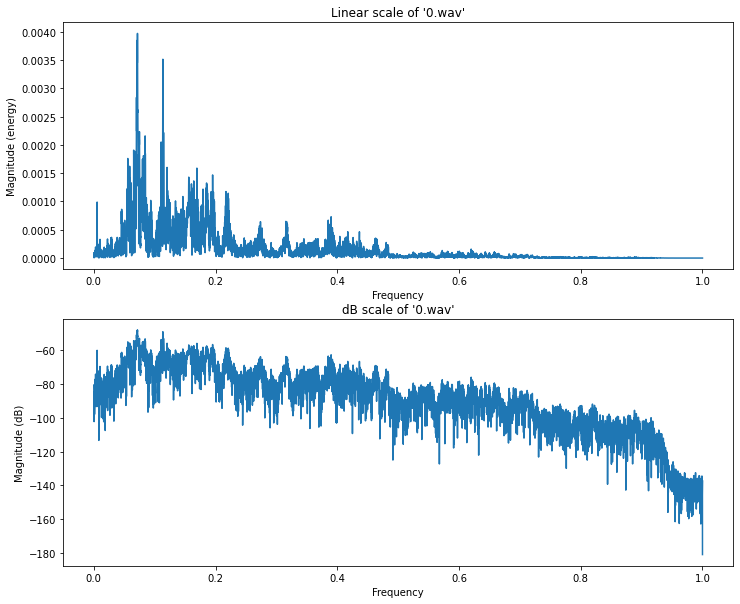

In [24]:
# Plot frequency domain

# set figure dimension
plt.figure(figsize=(12,10))

# plot linear energy over frequency 
plt.subplot(2,1,1)
plt.title(f"Linear scale of '{filenames[0]}'")
plt.magnitude_spectrum(signal, scale='linear')
# plot log energy over frequency (as human perceive)
plt.subplot(2,1,2)
plt.title(f"dB scale of '{filenames[0]}'")
plt.magnitude_spectrum(signal, scale='dB')


By inspection, we can say that all audios have been sampled with the same sampling rate

## Denoise

In [11]:
import noisereduce as nr

/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_6406/1840557170.py:6: FutureWarning: Pass sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sr, label='original', alpha=.3)#, ax=ax[i])
/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_6406/1840557170.py:10: FutureWarning: Pass sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(reduced_signal, sr, label='denoised', alpha=.9, color='tab:blue')#, ax=ax[i])


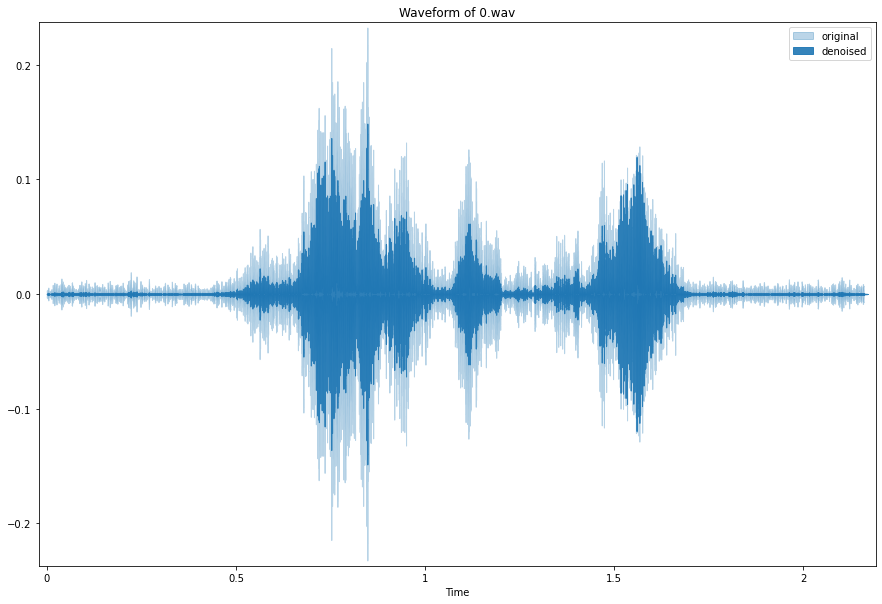

In [13]:
audio_file = audio_path+filenames[0]
signal, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast', mono=True)
#print(librosa.feature.spectral_centroid(signal, sr)[0].shape)
plt.figure(figsize=(15,10))
plt.title(f'Waveform of {filenames[0]}')
librosa.display.waveshow(signal, sr, label='original', alpha=.3)#, ax=ax[i])
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters

reduced_signal = nr.reduce_noise(signal, sr)
librosa.display.waveshow(reduced_signal, sr, label='denoised', alpha=.9, color='tab:blue')#, ax=ax[i])
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.legend()
plt.show()

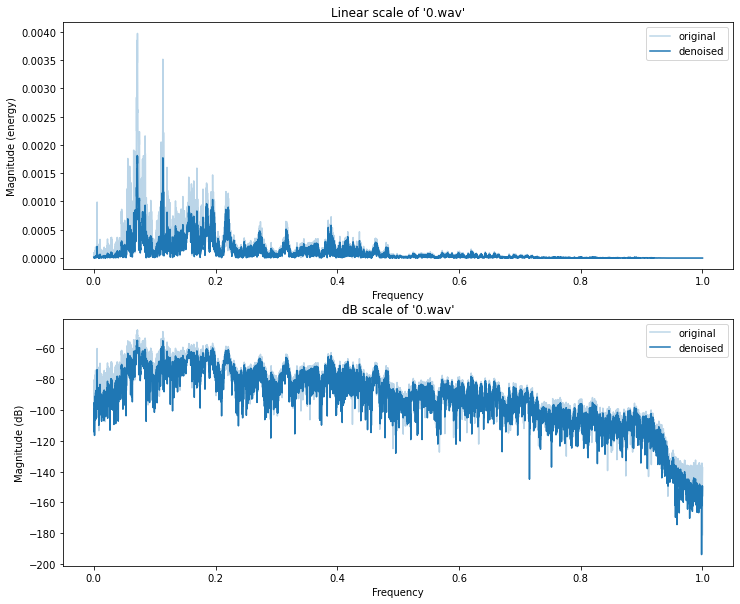

In [22]:
# differences in frequency domain

# set figure dimension
plt.figure(figsize=(12,10))

# plot linear energy over frequency 
plt.subplot(2,1,1)
plt.title(f"Linear scale of '{filenames[0]}'")
plt.magnitude_spectrum(signal, scale='linear', alpha=.3, label='original')
plt.magnitude_spectrum(reduced_signal, scale='linear', label='denoised', color='tab:blue')

plt.legend()

# plot log energy over frequency (as human perceive)
plt.subplot(2,1,2)
plt.title(f"dB scale of '{filenames[0]}'")
plt.magnitude_spectrum(signal, scale='dB', alpha=.3, label='original')
plt.magnitude_spectrum(reduced_signal, scale='dB', label='denoised', color='tab:blue')

plt.legend()

## Remove leading and trailing silences

/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_6406/4218839378.py:8: FutureWarning: Pass sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sr)
/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_6406/4218839378.py:13: FutureWarning: Pass sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(trimmed_signal, sr)


Text(0.5, 1.0, "Trimmed and denoised waveform of '0.wav'")

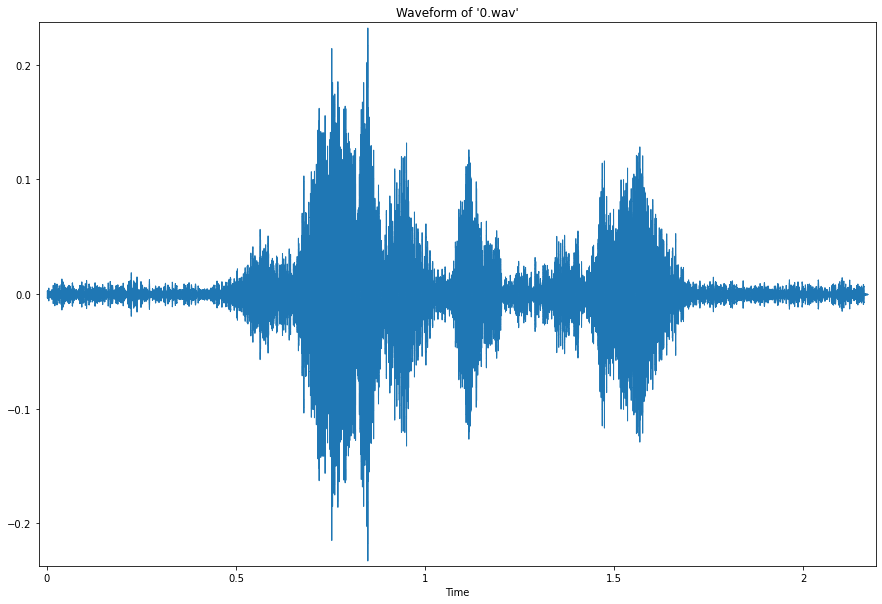

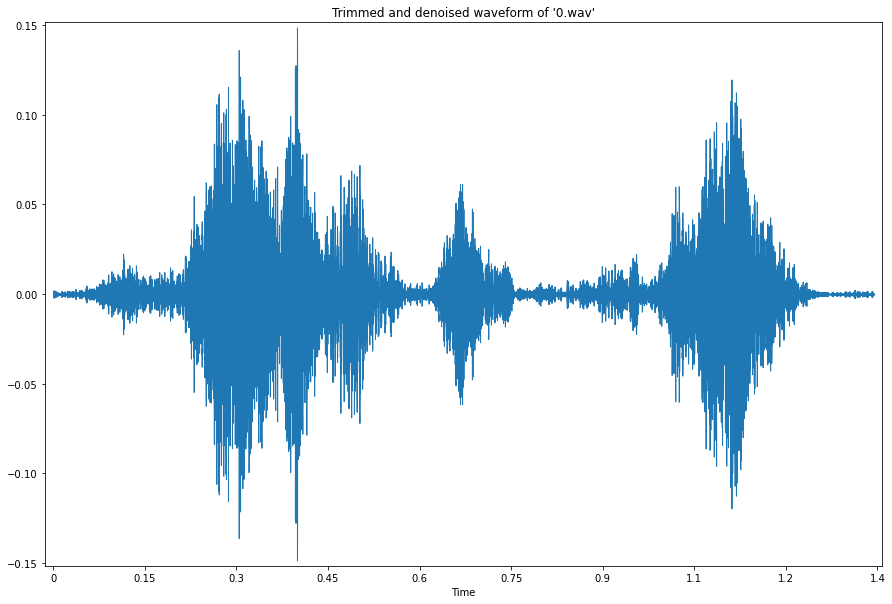

In [74]:
# audio file 0
audio_file = audio_path+filenames[0]
signal, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast', mono=True)
reduced_signal = nr.reduce_noise(signal, sr)
# trim using librosa and default dB threshold
trimmed_signal, index = librosa.effects.trim(reduced_signal, top_db=30)

plt.figure(figsize=(15,10))
librosa.display.waveshow(signal, sr)
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.title(f"Waveform of '{filenames[0]}'")

plt.figure(figsize=(15,10))
librosa.display.waveshow(trimmed_signal, sr)
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.title(f"Trimmed and denoised waveform of '{filenames[0]}'")

/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_6406/3631203805.py:9: FutureWarning: Pass sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(signal, sr)
/var/folders/2q/7qslh1r50qv5dxqpmmm9jcy00000gn/T/ipykernel_6406/3631203805.py:14: FutureWarning: Pass sr=8000 as keyword args. From version 0.10 passing these as positional arguments will result in an error
  librosa.display.waveshow(trimmed_signal, sr)


Text(0.5, 1.0, "Trimmed and denoised waveform of '2.wav'")

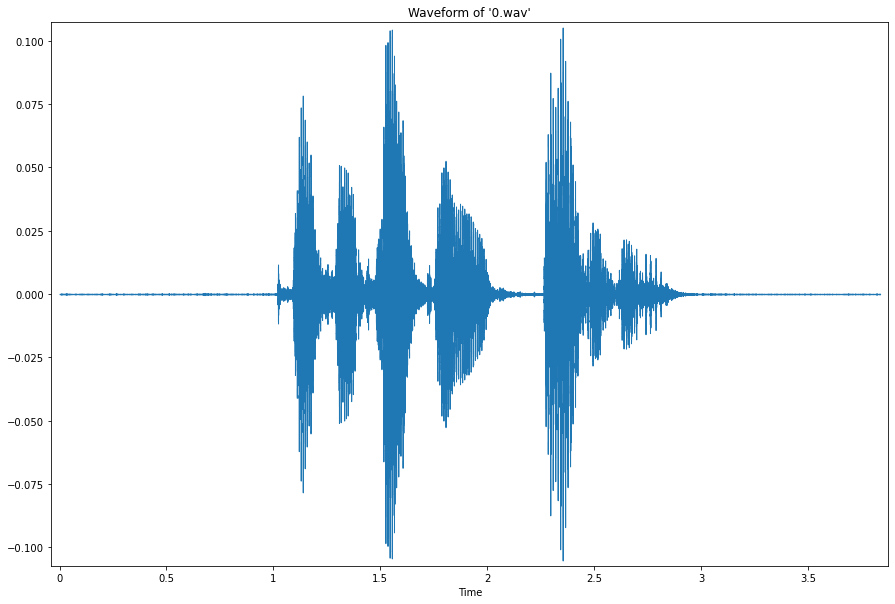

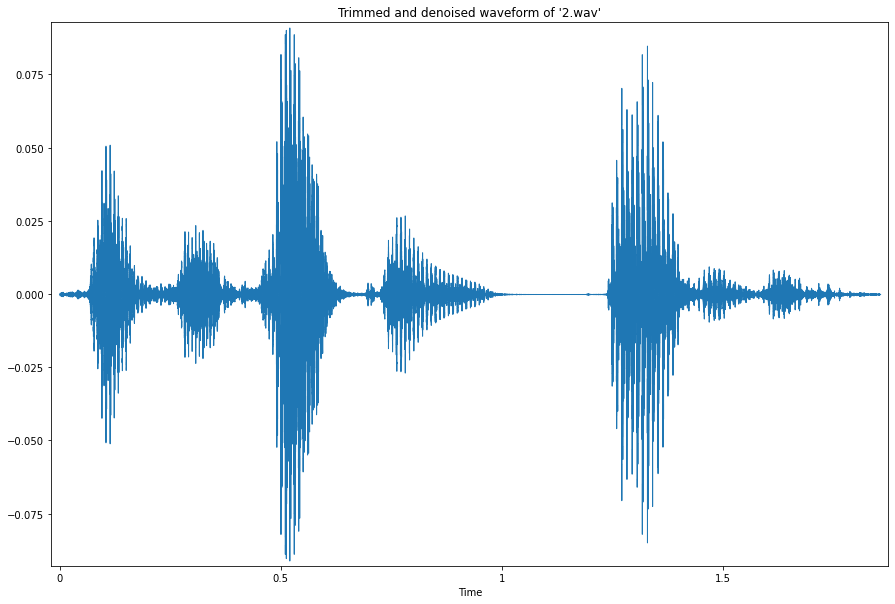

In [75]:
# audio file 3
audio_file = audio_path+filenames[3]
signal, sr = librosa.load(audio_file, sr=None, res_type='kaiser_fast', mono=True)
reduced_signal = nr.reduce_noise(signal, sr)
# trim using librosa and default dB threshold
trimmed_signal, index = librosa.effects.trim(reduced_signal, top_db=30)

plt.figure(figsize=(15,10))
librosa.display.waveshow(signal, sr)
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.title(f"Waveform of '{filenames[0]}'")

plt.figure(figsize=(15,10))
librosa.display.waveshow(trimmed_signal, sr)
plt.margins(x=0.01, y=0.01) # set to 1% to margin parameters
plt.title(f"Trimmed and denoised waveform of '{filenames[2]}'")

By checking manually, 30 db is a good threshold to remoive leading and trailing silences.